In [1]:
import os
import tarfile
from mxnet import gluon

data_root = '../data'
voc_root = data_root + '/VOCdevkit/VOC2012'
url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
       '/VOCtrainval_11-May-2012.tar')
sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'

fname = gluon.utils.download(url, data_root, sha1_hash=sha1)

if not os.path.isfile(voc_root+'/ImageSets/Segmentation/train.txt'):
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_root)


In [2]:
from mxnet import image

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + (
        'train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    n = len(images)
    data, label = [None] * n, [None] * n
    for i, fname in enumerate(images):
        data[i] = image.imread('%s/JPEGImages/%s.jpg' % (
            root, fname))
        label[i] = image.imread('%s/SegmentationClass/%s.png' % (
            root, fname))
    return data, label

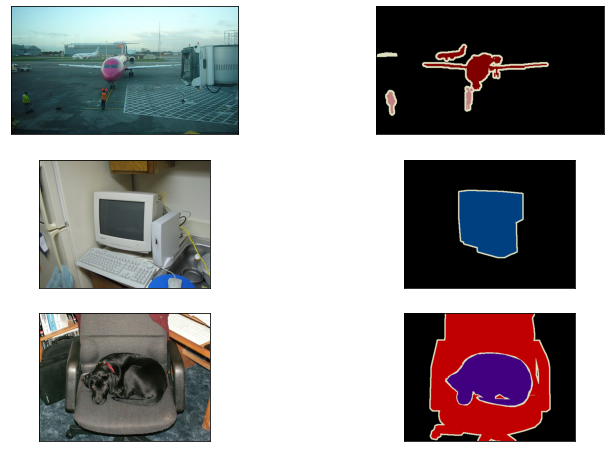

[(281, 500, 3),
 (281, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3)]

In [3]:
import sys
sys.path.append('..')
import utils

train_images, train_labels = read_images()

imgs = []
for i in range(3):
    imgs += [train_images[i], train_labels[i]]

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))
[im.shape for im in imgs]

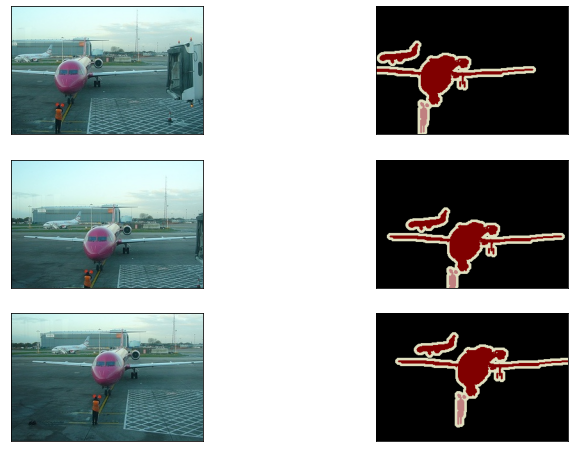

In [4]:
def rand_crop(data, label, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    return data, label

imgs = []
for _ in range(3):
    imgs += rand_crop(train_images[0], train_labels[0],
                      200, 300)

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

In [5]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [6]:
import numpy as np
from mxnet import nd

cm2lbl = np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i

def image2label(im):
    data = im.astype('int32').asnumpy()
    idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return nd.array(cm2lbl[idx])

In [7]:
y = image2label(train_labels[0])
y[105:115, 130:140]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
<NDArray 10x10 @cpu(0)>

In [9]:
from mxnet import gluon
from mxnet import nd


rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

class VOCSegDataset(gluon.data.Dataset):

    def _filter(self, images):
        return [im for im in images if (
            im.shape[0] >= self.crop_size[0] and
            im.shape[1] >= self.crop_size[1])]

    def __init__(self, train, crop_size):
        self.crop_size = crop_size
        data, label = read_images(train=train)
        data = self._filter(data)
        self.data = [normalize_image(im) for im in data]
        self.label = self._filter(label)
        print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
        data, label = rand_crop(
            self.data[idx], self.label[idx],
            *self.crop_size)
        data = data.transpose((2,0,1))
        label = image2label(label)
        return data, label

    def __len__(self):
        return len(self.data)

input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape)
voc_test = VOCSegDataset(False, input_shape)

Read 1114 examples
Read 1078 examples


In [10]:

batch_size = 64
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle=True,last_batch='discard')
test_data = gluon.data.DataLoader(
    voc_test, batch_size,last_batch='discard')

for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)
